In [473]:
# Dependencies
import pandas as pd
from pathlib import Path
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime

In [474]:
# --- Set filepath for file to analyze ---
# NOTE: Edit this for each new file being run
zillow_csv_path = Path('Zillow_Data/Metro_invt_fs_uc_sfrcondo_sm_month.csv')
zillow_metric_name = 'Inventory'

In [475]:
# --- Create a data frame containing the data from the CSV ---
# Load the CSV
zillow_df = pd.read_csv(zillow_csv_path)
# Insert 'US' as the state name for the United States region, so it shows up in state summary
zillow_df.at[0,"StateName"] = 'US'
# Rename labels
zillow_df.rename(columns={'SizeRank': 'Size Rank', 'RegionName': 'Metro Area', 'StateName': 'State' }, inplace=True)
# Remove the RegionType column
zillow_df = zillow_df.drop('RegionType', axis = 1)
# Insert a new blank column to store the Size Segment
zillow_df['Size Segment'] = pd.NA
# Re-order columns so that Size Segment is next to Size Rank
columns = zillow_df.columns.tolist()
columns.remove('Size Segment')
columns.insert(2, 'Size Segment')
zillow_df = zillow_df[columns]
# Establish Size Segments as bins
size_segment_bins = [-1, 0, 100, 200, 300, 400, 500, 1000]
size_segment_labels = ["National Average", "Top 100", "101 - 200", "201 - 300", "301 - 400", "401 - 500", "Bottom 500"]
# Insert segment values into Size Segment column
zillow_df['Size Segment'] = pd.cut(zillow_df["Size Rank"], bins=size_segment_bins, labels=size_segment_labels)
# Select only the columns with date information and the 'Size Segment' column
date_columns = [col for col in zillow_df.columns if isinstance(col, str) and col.startswith('2018') or col.startswith('2019') or col.startswith('2020') or col.startswith('2021') or col.startswith('2022') or col.startswith('2023')]
columns_of_interest = ['RegionID', 'Size Rank', 'Size Segment', 'Metro Area', 'State'] + date_columns
zillow_df= zillow_df[columns_of_interest]

# Create a unique data frame which is named after the metric currently being analyzed:
# Set the df name as a string equal to the zillow metric name, with spaces replaced with underscores and in all lowercase
zillow_unique_df_name = zillow_metric_name.replace(" ", "_").lower() + "_df"
globals()[zillow_unique_df_name] = zillow_df.copy()
print(f'Created new dataframe: {zillow_unique_df_name}')
# Print the first few rows of the DataFrame
print(zillow_df.head())


Created new dataframe: inventory_df
   RegionID  Size Rank      Size Segment       Metro Area State  2018-03-31  \
0    102001          0  National Average    United States    US   1421529.0   
1    394913          1           Top 100     New York, NY    NY     73707.0   
2    753899          2           Top 100  Los Angeles, CA    CA     21998.0   
3    394463          3           Top 100      Chicago, IL    IL     38581.0   
4    394514          4           Top 100       Dallas, TX    TX     24043.0   

   2018-04-30  2018-05-31  2018-06-30  2018-07-31  ...  2023-03-31  \
0   1500193.0   1592414.0   1660614.0   1709143.0  ...    835429.0   
1     80345.0     85864.0     90067.0     91881.0  ...     43253.0   
2     23784.0     25605.0     27109.0     28811.0  ...     15214.0   
3     42253.0     45757.0     47492.0     48984.0  ...     20922.0   
4     25876.0     28225.0     30490.0     32408.0  ...     17053.0   

   2023-04-30  2023-05-31  2023-06-30  2023-07-31  2023-08-31  2023-

In [476]:
# --- Create a data frame segmented by state ---
# Create a data frame that summarizes the data by size segment
state_summary_df = zillow_df.groupby('State').mean('State').drop('RegionID',  axis = 1).drop('Size Rank',  axis = 1)
state_summary_df.reset_index(inplace=True)
state_summary_df.rename(columns={'State': 'Date'}, inplace = True)
state_summary_df.set_index('Date', inplace=True)
state_summary_df = state_summary_df.T
state_summary_df.reset_index(inplace=True)
state_summary_df.rename(columns={'index': 'Date'}, inplace=True)
state_summary_df['Date'] = pd.to_datetime(state_summary_df['Date'])
# Copy to uniquely named data frame
state_unique_df_name = zillow_metric_name.replace(" ", "_").lower() + "_df_state"
globals()[state_unique_df_name] = state_summary_df.copy()
print(f'Created new dataframe: {state_unique_df_name}')
print(state_summary_df.head())

Created new dataframe: inventory_df_state
Date       Date      AK       AL      AR           AZ           CA  \
0    2018-03-31  595.75  1279.05  696.60  3738.636364  2445.882353   
1    2018-04-30  637.75  1327.60  726.10  3819.727273  2652.500000   
2    2018-05-31  701.75  1372.55  761.65  3842.636364  2875.205882   
3    2018-06-30  761.00  1396.70  789.40  3774.090909  3047.176471   
4    2018-07-31  823.50  1397.40  805.35  3657.181818  3218.323529   

Date           CO      CT      DE           FL  ...           TN           TX  \
0     1182.647059  3309.4  2809.5  5911.241379  ...  1136.307692  1509.044776   
1     1300.764706  3631.2  2951.5  6012.344828  ...  1185.884615  1600.223881   
2     1451.000000  4033.2  3071.5  6032.724138  ...  1251.692308  1709.134328   
3     1576.705882  4376.4  3147.5  5902.000000  ...  1307.423077  1793.089552   
4     1668.647059  4411.4  3110.5  5767.620690  ...  1355.500000  1861.194030   

Date         US           UT           VA      VT 

In [477]:
# --- Create a data frame segmented by size rank ---
# Group by 'Size Segment' and calculate the mean for each segment
zillow_df_mean = zillow_df.groupby('Size Segment', observed = False).mean('Size Segment').drop('RegionID',  axis = 1).drop('Size Rank',  axis = 1)
# Reset the index for better display
zillow_df_mean.reset_index(inplace=True)
zillow_df_mean.rename(columns={'Size Segment': 'Date'}, inplace = True)
zillow_df_mean.set_index('Date', inplace=True)
zillow_df_mean = zillow_df_mean.T
zillow_df_mean.reset_index(inplace=True)
zillow_df_mean.rename(columns={'index': 'Date'}, inplace=True)
zillow_df_mean['Date'] = pd.to_datetime(zillow_df_mean['Date'])
# Create uniquely named data frame
size_unique_df_name = zillow_metric_name.replace(" ", "_").lower() + "_df_size"
globals()[size_unique_df_name] = zillow_df_mean.copy()
print(f'Created new dataframe: {size_unique_df_name }')
print(zillow_df_mean.head())

Created new dataframe: inventory_df_size
Date       Date  National Average       Top 100    101 - 200    201 - 300  \
0    2018-03-31         1421529.0   8455.387755  1836.171717   995.642857   
1    2018-04-30         1500193.0   9016.153061  1915.979798  1038.612245   
2    2018-05-31         1592414.0   9623.020408  2011.222222  1087.653061   
3    2018-06-30         1660614.0  10008.408163  2071.777778  1127.071429   
4    2018-07-31         1709143.0  10245.183673  2121.707071  1159.918367   

Date   301 - 400   401 - 500  Bottom 500  
0     569.153061  460.670103  217.046569  
1     592.979592  474.773196  225.093137  
2     628.387755  495.917526  237.549020  
3     663.795918  517.505155  250.652812  
4     692.704082  536.804124  261.897311  


In [478]:
interest_rates_csv_path = Path('Zillow_Data/fed-funds-rate-historical-chart-modified.csv')
interest_rates_df = pd.read_csv(interest_rates_csv_path)
interest_rates_df['Date'] = pd.to_datetime(interest_rates_df['Date'])
interest_rates_df

,Date,Federal Funds Rate
0,1954-07-01,1.13
1,1954-07-02,1.25
2,1954-07-03,1.25
3,1954-07-04,1.25
4,1954-07-05,0.88
...,...,...
24914,2024-08-24,NaN
24915,2024-08-25,NaN
24916,2024-08-26,NaN
24917,2024-08-27,NaN


In [479]:
# Merge inventory data with interest rates
inventory_vs_interest_rate_df = pd.merge(inventory_df_size, interest_rates_df, on="Date", how='inner')

# Display the merged DataFrame
inventory_vs_interest_rate_df



,Date,National Average,Top 100,101 - 200,201 - 300,301 - 400,401 - 500,Bottom 500,Federal Funds Rate
0,2018-03-31,1421529.0,8455.387755,1836.171717,995.642857,569.153061,460.670103,217.046569,1.67
1,2018-04-30,1500193.0,9016.153061,1915.979798,1038.612245,592.979592,474.773196,225.093137,1.69
2,2018-05-31,1592414.0,9623.020408,2011.222222,1087.653061,628.387755,495.917526,237.549020,1.70
3,2018-07-31,1709143.0,10245.183673,2121.707071,1159.918367,692.704082,536.804124,261.897311,1.91
4,2018-08-31,1733388.0,10330.959184,2153.080808,1180.081633,710.836735,550.072165,269.388753,1.91
5,2018-10-31,1701371.0,10184.387755,2113.939394,1157.234694,694.765306,536.319588,261.677262,2.20
6,2018-11-30,1642145.0,9876.081633,2038.464646,1113.714286,662.673469,513.164948,249.872861,2.20
7,2018-12-31,1541994.0,9270.418367,1926.888889,1047.785714,617.877551,481.876289,233.911980,2.40
8,2019-01-31,1452603.0,8737.346939,1828.181818,990.683673,575.795918,453.659794,219.097800,2.40
9,2019-02-28,1405515.0,8492.561224,1771.606061,960.948980,547.510204,436.443299,209.608802,2.40


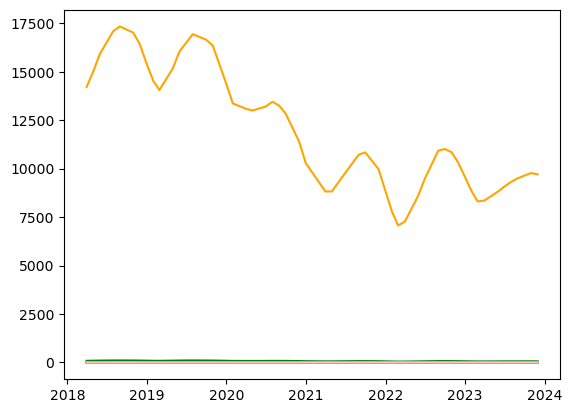

In [480]:
# Plot inventory data against interest rates
plt.plot(inventory_vs_interest_rate_df['Date'], inventory_vs_interest_rate_df['National Average'] / 100, label = "National Average", color = "orange")
plt.plot(inventory_vs_interest_rate_df['Date'], inventory_vs_interest_rate_df['Federal Funds Rate'] / 10, label = "Federal Funds Rate", color = "red")
plt.plot(inventory_vs_interest_rate_df['Date'], inventory_vs_interest_rate_df['Top 100'] / 100, label = "Top 100", color = "green")
plt.plot(inventory_vs_interest_rate_df['Date'], inventory_vs_interest_rate_df['101 - 200'] / 100, label = "101 - 200", color = "blue")
plt.plot(inventory_vs_interest_rate_df['Date'], inventory_vs_interest_rate_df['201 - 300'] / 100, label = "201 - 300", color = "purple")
plt.plot(inventory_vs_interest_rate_df['Date'], inventory_vs_interest_rate_df['301 - 400'] / 100, label = "301 - 400", color = "violet")
plt.plot(inventory_vs_interest_rate_df['Date'], inventory_vs_interest_rate_df['Bottom 500'] / 100, label = "Bottom 500", color = "pink")

# Format plot


In [481]:
# Calculate correlation between Inventory National Average and Federal Funds Rate
corr_inventory_national_interest_rates = inventory_vs_interest_rate_df['National Average'].corr(inventory_vs_interest_rate_df['Federal Funds Rate'])
corr_inventory_national_interest_rates


-0.10479027378438015

In [482]:
# Define the date range for the pandemic period
start_date = '2020-01-01'
end_date = '2021-12-31'

# Filter the DataFrame for the pandemic period
inventory_vs_interest_rate_df_pandemic = inventory_vs_interest_rate_df[(inventory_vs_interest_rate_df['Date'] >= start_date) & (inventory_vs_interest_rate_df['Date'] <= end_date)]

# Calculate the correlation between Inventory National Average and Federal Funds Rate during the pandemic period
corr_inventory_national_interest_rates_pandemic = inventory_vs_interest_rate_df_pandemic['National Average'].corr(inventory_vs_interest_rate_df_pandemic['Federal Funds Rate'])
corr_inventory_national_interest_rates_pandemic


0.3160734482064571

In [483]:
# Define the date range for the post-pandemic period
start_date = '2022-01-01'
end_date = '2023-12-31'

# Filter the DataFrame for the post-pandemic period
inventory_vs_interest_rate_df_postpandemic = inventory_vs_interest_rate_df[(inventory_vs_interest_rate_df['Date'] >= start_date) & (inventory_vs_interest_rate_df['Date'] <= end_date)]

# Calculate the correlation between Inventory National Average and Federal Funds Rate during the post-pandemic period
corr_inventory_national_interest_rates_postpandemic = inventory_vs_interest_rate_df_postpandemic['National Average'].corr(inventory_vs_interest_rate_df_postpandemic['Federal Funds Rate'])
corr_inventory_national_interest_rates_postpandemic


0.3940765760198499

In [484]:
# Merge the state-level inventory DataFrame with interest rates DataFrame
state_inventory_index_vs_interest_rate_df = pd.merge(inventory_df_state, interest_rates_df, on="Date", how='inner')
state_inventory_index_vs_interest_rate_df


,Date,AK,AL,AR,AZ,CA,CO,CT,DE,FL,...,TX,US,UT,VA,VT,WA,WI,WV,WY,Federal Funds Rate
0,2018-03-31,595.75,1279.050000,696.600000,3738.636364,2445.882353,1182.647059,3309.4,2809.5,5911.241379,...,1509.044776,1421529.0,1015.000000,3167.785714,525.75,855.45,734.304348,524.625,336.000000,1.67
1,2018-04-30,637.75,1327.600000,726.100000,3819.727273,2652.500000,1300.764706,3631.2,2951.5,6012.344828,...,1600.223881,1500193.0,1094.666667,3504.428571,538.00,936.25,805.478261,538.500,344.888889,1.69
2,2018-05-31,701.75,1372.550000,761.650000,3842.636364,2875.205882,1451.000000,4033.2,3071.5,6032.724138,...,1709.134328,1592414.0,1215.555556,3813.642857,573.75,1095.80,900.304348,562.375,366.444444,1.70
3,2018-07-31,823.50,1397.400000,805.350000,3657.181818,3218.323529,1668.647059,4411.4,3110.5,5767.620690,...,1861.194030,1709143.0,1402.888889,3841.714286,720.75,1341.70,1023.521739,605.875,407.000000,1.91
4,2018-08-31,864.75,1391.200000,814.250000,3554.818182,3325.529412,1719.117647,4394.2,3027.5,5672.965517,...,1896.000000,1733388.0,1469.777778,3742.785714,803.25,1396.80,1052.478261,616.125,413.777778,1.91
5,2018-10-31,810.75,1325.200000,798.550000,3494.090909,3406.352941,1691.529412,4210.2,2809.5,5596.724138,...,1821.388060,1701371.0,1527.111111,3610.785714,838.00,1401.70,1047.347826,607.625,390.000000,2.20
6,2018-11-30,731.75,1271.750000,778.400000,3545.727273,3323.117647,1609.058824,4022.6,2702.5,5621.000000,...,1747.597015,1642145.0,1484.444444,3466.142857,789.25,1302.25,989.565217,586.375,361.777778,2.20
7,2018-12-31,644.75,1201.750000,746.250000,3466.272727,3098.735294,1456.529412,3665.0,2569.0,5630.793103,...,1657.522388,1541994.0,1379.444444,3176.857143,727.75,1127.40,895.956522,547.875,326.222222,2.40
8,2019-01-31,576.50,1150.750000,719.850000,3447.454545,2889.647059,1323.117647,3296.0,2434.5,5780.551724,...,1593.671642,1452603.0,1278.000000,2881.857143,656.25,969.10,797.434783,509.250,299.555556,2.40
9,2019-02-28,546.00,1129.050000,707.350000,3424.636364,2780.500000,1256.882353,3098.6,2384.0,5987.172414,...,1576.298507,1405515.0,1218.333333,2702.000000,615.75,855.60,739.521739,482.125,283.222222,2.40


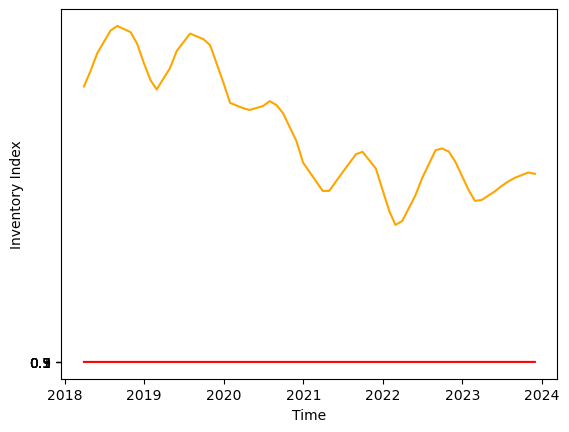

In [485]:
# Plot the state-level inventory data against interest rates
plt.plot(state_inventory_index_vs_interest_rate_df['Date'], state_inventory_index_vs_interest_rate_df['US']/100, label = "National Average", color = "orange")
plt.plot(state_inventory_index_vs_interest_rate_df['Date'], state_inventory_index_vs_interest_rate_df['Federal Funds Rate']/10, label = "Federal Funds Rate", color  = "red")

# Format the x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set labels and ticks
plt.xlabel("Time")
plt.ylabel("Inventory Index")
plt.yticks([0.10, 0.30, 0.50, 0.70, 0.90])

# Show the plot
plt.show()


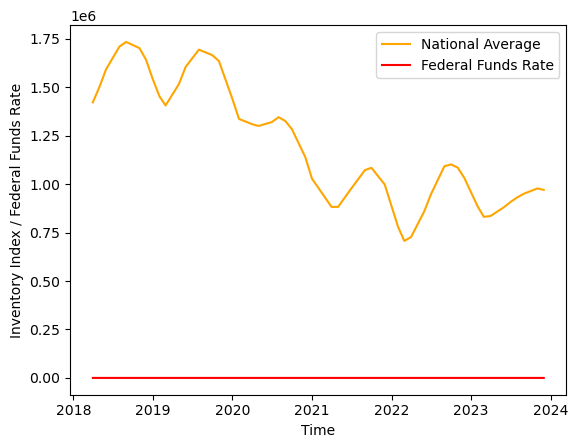

In [486]:
# Plot the state-level inventory data against interest rates
plt.plot(state_inventory_index_vs_interest_rate_df['Date'], state_inventory_index_vs_interest_rate_df['US'], label = "National Average", color = "orange")
plt.plot(state_inventory_index_vs_interest_rate_df['Date'], state_inventory_index_vs_interest_rate_df['Federal Funds Rate'], label = "Federal Funds Rate", color  = "red")

# Format the x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set labels and ticks
plt.xlabel("Time")
plt.ylabel("Inventory Index / Federal Funds Rate")

# Adding a legend
plt.legend()

# Show the plot
plt.show()


In [487]:
# Reshape the DataFrame from wide to long format
zillow_df_long = zillow_df.melt(id_vars=['RegionID', 'Size Rank', 'Size Segment', 'Metro Area', 'State'], 
                                var_name='Date', 
                                value_name=zillow_metric_name)
# Convert Date column to datetime format
zillow_df_long['Date'] = pd.to_datetime(zillow_df_long['Date'], format='%Y-%m-%d')

# Set Date as index
zillow_df_long.set_index('Date', inplace=True)

# Ensure data is sorted by Date
zillow_df_long.sort_index(inplace=True)


# Debugging: Print the first few rows to verify the reshaping and date conversion
print("Data after reshaping and date conversion:")
print(zillow_df_long.head())

# Ensure there are no NaN values in the metric column before calculating percent change
zillow_df_long[zillow_metric_name] = zillow_df_long[zillow_metric_name].ffill()

# Calculate month-to-month percent change for the chosen metric
zillow_df_long[f'{zillow_metric_name} Percent Change'] = zillow_df_long.groupby(['RegionID', 'Size Rank', 'Size Segment', 'Metro Area', 'State'], observed=True)[zillow_metric_name].pct_change() * 100 
# Create a unique DataFrame named after the metric being analyzed
zillow_unique_df_name = zillow_metric_name.replace(" ", "_").lower() + "_df"
globals()[zillow_unique_df_name] = zillow_df_long.copy()
print(f'Created new dataframe: {zillow_unique_df_name}')

# Display the updated DataFrame
print(zillow_df_long.head(2000))


Data after reshaping and date conversion:
            RegionID  Size Rank      Size Segment       Metro Area State  \
Date                                                                       
2018-03-31    102001          0  National Average    United States    US   
2018-03-31    394913          1           Top 100     New York, NY    NY   
2018-03-31    753899          2           Top 100  Los Angeles, CA    CA   
2018-03-31    394463          3           Top 100      Chicago, IL    IL   
2018-03-31    394514          4           Top 100       Dallas, TX    TX   

            Inventory  
Date                   
2018-03-31  1421529.0  
2018-03-31    73707.0  
2018-03-31    21998.0  
2018-03-31    38581.0  
2018-03-31    24043.0  
Created new dataframe: inventory_df
            RegionID  Size Rank      Size Segment       Metro Area State  \
Date                                                                       
2018-03-31    102001          0  National Average    United States   

In [488]:
# Reshape the DataFrame from wide to long format
zillow_df_long = zillow_df.melt(id_vars=['RegionID', 'Size Rank', 'Size Segment', 'Metro Area', 'State'], 
                                var_name='Date', 
                                value_name=zillow_metric_name)

# Convert Date column to datetime format
zillow_df_long['Date'] = pd.to_datetime(zillow_df_long['Date'], format='%Y-%m-%d')

# Set Date as index
zillow_df_long.set_index('Date', inplace=True)

# Ensure data is sorted by Date
zillow_df_long.sort_index(inplace=True)

# Debugging: Print the first few rows to verify the reshaping and date conversion
print("Data after reshaping and date conversion:")
print(zillow_df_long.head())

# Ensure there are no NaN values in the metric column before calculating percent change
zillow_df_long[zillow_metric_name] = zillow_df_long[zillow_metric_name].ffill()

# Extract Year and Month from the Date
zillow_df_long['Year'] = zillow_df_long.index.year
zillow_df_long['Month'] = zillow_df_long.index.month

# Ensure the Date column is set as index again after adding Year and Month
zillow_df_long.set_index(['RegionID', 'Size Rank', 'Size Segment', 'Metro Area', 'State', 'Year'], inplace=True)

# Create a DataFrame to calculate yearly percent change
def calculate_yearly_percent_change(df):
    # Get the rent index values for January and December
    january_values = df[df['Month'] == 1].groupby('Year')[zillow_metric_name].first()
    december_values = df[df['Month'] == 12].groupby('Year')[zillow_metric_name].last()
        # Merge January and December values into a single DataFrame
    year_df = pd.DataFrame({
        'Inventory Index_Jan': january_values,
        'Inventory Index_Dec': december_values
    }).dropna()
    
    # Calculate the percent change
    year_df['Yearly Percent Change'] = ((year_df['Inventory Index_Dec'] - year_df['Inventory Index_Jan']) / year_df['Inventory Index_Jan']) * 100
    
    # Reset index to include Year
    year_df.reset_index(inplace=True)
    return year_df

# Apply the function to each region and metric combination
yearly_percent_changes = zillow_df_long.groupby(['RegionID', 'Size Rank', 'Size Segment', 'Metro Area', 'State'], observed=True).apply(calculate_yearly_percent_change).reset_index(drop=True)

# Create a unique DataFrame named after the metric being analyzed
zillow_unique_df_name = zillow_metric_name.replace(" ", "_").lower() + "_yearly_percent_change_df"
globals()[zillow_unique_df_name] = yearly_percent_changes

print(f'Created new dataframe: {zillow_unique_df_name}')

# Display the updated DataFrame
print(yearly_percent_changes.head())





Data after reshaping and date conversion:
            RegionID  Size Rank      Size Segment       Metro Area State  \
Date                                                                       
2018-03-31    102001          0  National Average    United States    US   
2018-03-31    394913          1           Top 100     New York, NY    NY   
2018-03-31    753899          2           Top 100  Los Angeles, CA    CA   
2018-03-31    394463          3           Top 100      Chicago, IL    IL   
2018-03-31    394514          4           Top 100       Dallas, TX    TX   

            Inventory  
Date                   
2018-03-31  1421529.0  
2018-03-31    73707.0  
2018-03-31    21998.0  
2018-03-31    38581.0  
2018-03-31    24043.0  
Created new dataframe: inventory_yearly_percent_change_df
   Year  Inventory Index_Jan  Inventory Index_Dec  Yearly Percent Change
0  2019            1452603.0            1441428.0              -0.769309
1  2020            1336187.0            1028143.0    

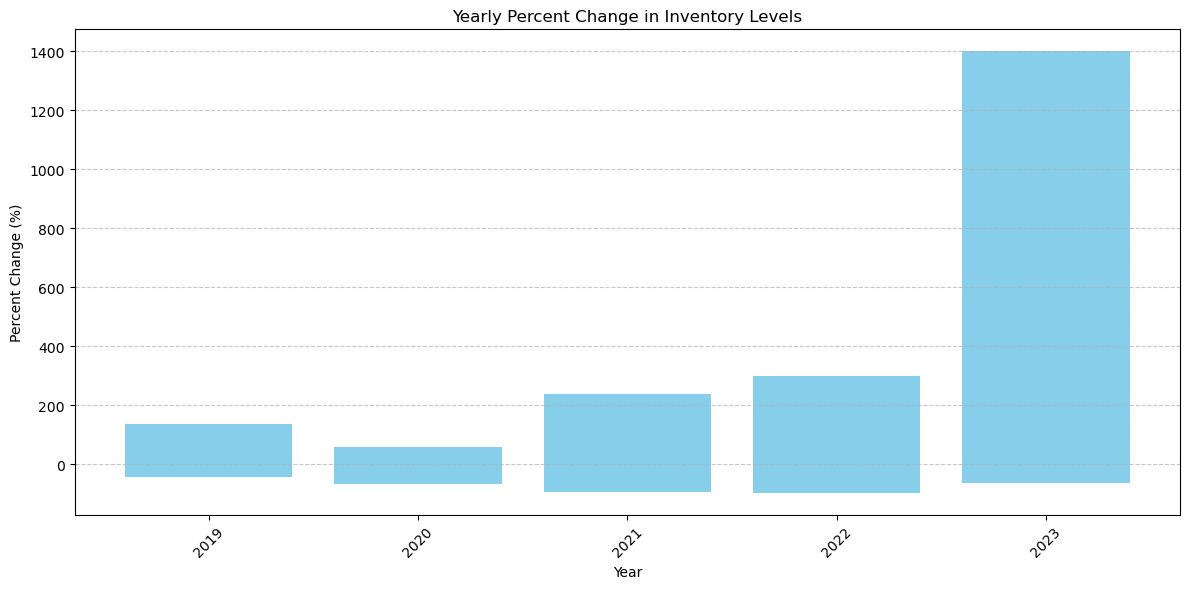

In [489]:
import matplotlib.pyplot as plt

# Create a bar plot for yearly percent change
plt.figure(figsize=(12, 6))
plt.bar(yearly_percent_changes['Year'], yearly_percent_changes['Yearly Percent Change'], color='skyblue')
plt.title('Yearly Percent Change in Inventory Levels')
plt.xlabel('Year')
plt.ylabel('Percent Change (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [490]:
import pandas as pd

# Forward fill missing values
large_cities_df_long['Inventory Index'] = large_cities_df_long['Inventory Index'].ffill()
small_cities_df_long['Inventory Index'] = small_cities_df_long['Inventory Index'].ffill()

# Ensure the 'Inventory Index' column is numeric
large_cities_df_long['Inventory Index'] = pd.to_numeric(large_cities_df_long['Inventory Index'], errors='coerce')
small_cities_df_long['Inventory Index'] = pd.to_numeric(small_cities_df_long['Inventory Index'], errors='coerce')

# Resample and calculate mean for large cities
large_cities_inventory_trends = large_cities_df_long.resample('ME').mean(numeric_only=True)

# Resample and calculate mean for smaller cities
small_cities_inventory_trends = small_cities_df_long.resample('ME').mean(numeric_only=True)

# Calculate mean inventory index
large_cities_mean_inventory = large_cities_inventory_trends['Inventory Index'].mean()
small_cities_mean_inventory = small_cities_inventory_trends['Inventory Index'].mean()

# Print the results
print(f"Mean Inventory Index for Large Cities: {large_cities_mean_inventory}")
print(f"Mean Inventory Index for Small Cities: {small_cities_mean_inventory}")


Mean Inventory Index for Large Cities: 19314.728
Mean Inventory Index for Small Cities: 466.1765873015873


In [491]:
# Check the structure and a few rows of each DataFrame
print("Large Cities DataFrame:")
print(large_cities_df_long.head())
print(large_cities_df_long.info())

print("\nSmall Cities DataFrame:")
print(small_cities_df_long.head())
print(small_cities_df_long.info())

Large Cities DataFrame:
            RegionID  Size Rank      Size Segment       Metro Area State  \
Date                                                                       
2018-03-31    102001          0  National Average    United States    US   
2018-03-31    394913          1           Top 100     New York, NY    NY   
2018-03-31    753899          2           Top 100  Los Angeles, CA    CA   
2018-03-31    394463          3           Top 100      Chicago, IL    IL   
2018-03-31    394514          4           Top 100       Dallas, TX    TX   

            Inventory Index  
Date                         
2018-03-31        1421529.0  
2018-03-31          73707.0  
2018-03-31          21998.0  
2018-03-31          38581.0  
2018-03-31          24043.0  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7000 entries, 2018-03-31 to 2023-12-31
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   RegionID  

In [492]:

# Forward fill missing values
large_cities_inventory_trends['Inventory Index'] = large_cities_inventory_trends['Inventory Index'].ffill()
small_cities_inventory_trends['Inventory Index'] = small_cities_inventory_trends['Inventory Index'].ffill()

# Ensure the 'Inventory Index' column is numeric
large_cities_inventory_trends['Inventory Index'] = pd.to_numeric(large_cities_inventory_trends['Inventory Index'], errors='coerce')
small_cities_inventory_trends['Inventory Index'] = pd.to_numeric(small_cities_inventory_trends['Inventory Index'], errors='coerce')

# Calculate statistics for large cities
large_cities_mode_inventory = large_cities_inventory_trends['Inventory Index'].mode()
large_cities_median_inventory = large_cities_inventory_trends['Inventory Index'].median()
large_cities_std_inventory = large_cities_inventory_trends['Inventory Index'].std()
large_cities_variance_inventory = large_cities_inventory_trends['Inventory Index'].var()

# Calculate statistics for small cities
small_cities_mode_inventory = small_cities_inventory_trends['Inventory Index'].mode()
small_cities_median_inventory = small_cities_inventory_trends['Inventory Index'].median()
small_cities_std_inventory = small_cities_inventory_trends['Inventory Index'].std()
small_cities_variance_inventory = small_cities_inventory_trends['Inventory Index'].var()

# Function to print mode and its count
def print_mode_and_count(df, label):
    mode_inventory = df['Inventory Index'].mode()
    if not mode_inventory.empty:
        # Print the most frequent mode and its count
        mode_counts = df['Inventory Index'].value_counts()
        most_frequent_mode = mode_inventory.iloc[0]
        most_frequent_count = mode_counts[most_frequent_mode]
        print(f"{label} Most Frequent Mode: {most_frequent_mode}")
        print(f"{label} Count of Most Frequent Mode: {most_frequent_count}")

# Print Large Cities Statistics
print("Large Cities Inventory Index Statistics:")
print_mode_and_count(large_cities_inventory_trends, "Large Cities")
print(f"Median: {large_cities_median_inventory}")
print(f"Standard Deviation: {large_cities_std_inventory}")
print(f"Variance: {large_cities_variance_inventory}")

# Print Small Cities Statistics
print("\nSmall Cities Inventory Index Statistics:")
print_mode_and_count(small_cities_inventory_trends, "Small Cities")
print(f"Median: {small_cities_median_inventory}")
print(f"Standard Deviation: {small_cities_std_inventory}")
print(f"Variance: {small_cities_variance_inventory}")


Large Cities Inventory Index Statistics:
Large Cities Most Frequent Mode: 11517.95
Large Cities Count of Most Frequent Mode: 1
Median: 17846.605
Standard Deviation: 4811.225153822637
Variance: 23147887.480775658

Small Cities Inventory Index Statistics:
Small Cities Most Frequent Mode: 286.40700483091786
Small Cities Count of Most Frequent Mode: 1
Median: 427.2554347826087
Standard Deviation: 121.47705516017432
Variance: 14756.674930388035


In [493]:

# Resample and calculate mean for large cities
large_cities_inventory_trends = large_cities_df_long.resample('ME').mean(numeric_only=True)

# Resample and calculate mean for small cities
small_cities_inventory_trends = small_cities_df_long.resample('ME').mean(numeric_only=True)

# Ensure the 'Inventory Index' column is numeric after resampling
large_cities_inventory_trends['Inventory Index'] = pd.to_numeric(large_cities_inventory_trends['Inventory Index'], errors='coerce')
small_cities_inventory_trends['Inventory Index'] = pd.to_numeric(small_cities_inventory_trends['Inventory Index'], errors='coerce')

# Calculate mode by year
def calculate_mode(series):
    try:
        return series.mode().iloc[0]  # Return the first mode if there are multiple
    except IndexError:
        return np.nan  # Return NaN if there are no values

# Calculate statistics by year for large cities
large_cities_stats_by_year = large_cities_inventory_trends.groupby(large_cities_inventory_trends.index.year).agg({
    'Inventory Index': [calculate_mode, 'median', 'std', 'var']
})

# Flatten the MultiIndex columns
large_cities_stats_by_year.columns = ['Mode', 'Median', 'Standard Deviation', 'Variance']

# Calculate statistics by year for small cities
small_cities_stats_by_year = small_cities_inventory_trends.groupby(small_cities_inventory_trends.index.year).agg({
    'Inventory Index': [calculate_mode, 'median', 'std', 'var']
})

# Flatten the MultiIndex columns
small_cities_stats_by_year.columns = ['Mode', 'Median', 'Standard Deviation', 'Variance']

# Display results
print("Large Cities Inventory Index Statistics by Year:")
print(large_cities_stats_by_year)

print("\nSmall Cities Inventory Index Statistics by Year:")
print(small_cities_stats_by_year)


Large Cities Inventory Index Statistics by Year:
          Mode     Median  Standard Deviation      Variance
Date                                                       
2018  22519.44  26281.915         1677.889103  2.815312e+06
2019  22397.09  25359.435         1767.106369  3.122665e+06
2020  16780.55  20810.720         1378.899747  1.901365e+06
2021  14389.98  15812.935         1317.666832  1.736246e+06
2022  11517.95  15589.780         2461.348772  6.058238e+06
2023  13559.14  14852.445          756.306343  5.719993e+05

Small Cities Inventory Index Statistics by Year:
            Mode      Median  Standard Deviation     Variance
Date                                                         
2018  573.076087  649.781401           40.036392  1602.912696
2019  552.577295  607.082126           36.697371  1346.697034
2020  367.466184  507.539251           49.511455  2451.384186
2021  323.568841  359.547101           38.097380  1451.410326
2022  286.407005  377.923913           57.865387 

In [494]:
from scipy import stats

# Example: Two-sample t-test for comparing inventory levels in 2020
large_cities_2020 = large_cities_df_long[large_cities_df_long.index.year == 2020]['Inventory Index']
small_cities_2020 = small_cities_df_long[small_cities_df_long.index.year == 2020]['Inventory Index']

t_stat, p_val = stats.ttest_ind(large_cities_2020.dropna(), small_cities_2020.dropna())
print(f"T-Statistic: {t_stat}, P-Value: {p_val}")


T-Statistic: 15.709848968217846, P-Value: 5.0385975458246966e-55


In [495]:
# Check the structure and a few rows of each DataFrame
print("Large Cities DataFrame:")
print(large_cities_df_long.head())
print(large_cities_df_long.info())

print("\nSmall Cities DataFrame:")
print(small_cities_df_long.head())
print(small_cities_df_long.info())


Large Cities DataFrame:
            RegionID  Size Rank      Size Segment       Metro Area State  \
Date                                                                       
2018-03-31    102001          0  National Average    United States    US   
2018-03-31    394913          1           Top 100     New York, NY    NY   
2018-03-31    753899          2           Top 100  Los Angeles, CA    CA   
2018-03-31    394463          3           Top 100      Chicago, IL    IL   
2018-03-31    394514          4           Top 100       Dallas, TX    TX   

            Inventory Index  
Date                         
2018-03-31        1421529.0  
2018-03-31          73707.0  
2018-03-31          21998.0  
2018-03-31          38581.0  
2018-03-31          24043.0  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7000 entries, 2018-03-31 to 2023-12-31
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   RegionID  

In [496]:
mean_large = large_cities_2020.mean()
mean_small = small_cities_2020.mean()
std_large = large_cities_2020.std()
std_small = small_cities_2020.std()
n_large = large_cities_2020.count()
n_small = small_cities_2020.count()

pooled_std = np.sqrt(((std_large**2 * (n_large - 1)) + (std_small**2 * (n_small - 1))) / (n_large + n_small - 2))
cohen_d = (mean_large - mean_small) / pooled_std
print(f"Cohen's d: {cohen_d}")


Cohen's d: 0.4801093972062412


In [497]:
# Combine large and small city data into a single DataFrame for ANOVA
combined_df = pd.concat([
    large_cities_df_long.assign(CitySize='Large'),
    small_cities_df_long.assign(CitySize='Small')
])

# Perform ANOVA for inventory index by year and city size
anova_results = stats.f_oneway(
    combined_df[(combined_df['CitySize'] == 'Large') & (combined_df.index.year == 2020)]['Inventory Index'].dropna(),
    combined_df[(combined_df['CitySize'] == 'Small') & (combined_df.index.year == 2020)]['Inventory Index'].dropna()
)
print(f"ANOVA F-Statistic: {anova_results.statistic}, P-Value: {anova_results.pvalue}")


ANOVA F-Statistic: 246.7993546042154, P-Value: 5.0385975458100496e-55


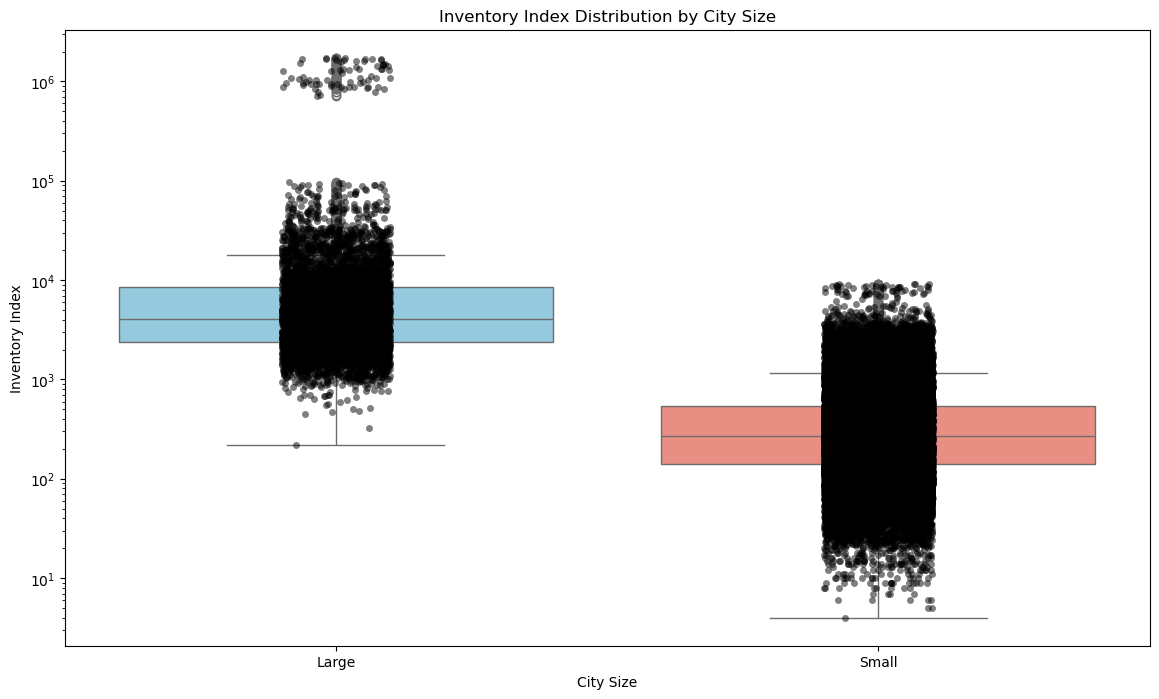

In [498]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.boxplot(x='CitySize', y='Inventory Index', data=combined_df, hue='CitySize', palette={'Large': 'skyblue', 'Small': 'salmon'}, dodge=False)
sns.stripplot(x='CitySize', y='Inventory Index', data=combined_df, color='k', alpha=0.5, jitter=True)
plt.title('Inventory Index Distribution by City Size')
plt.xlabel('City Size')
plt.ylabel('Inventory Index')
plt.yscale('log')  # Apply a logarithmic scale if the data spans multiple orders of magnitude
plt.show()



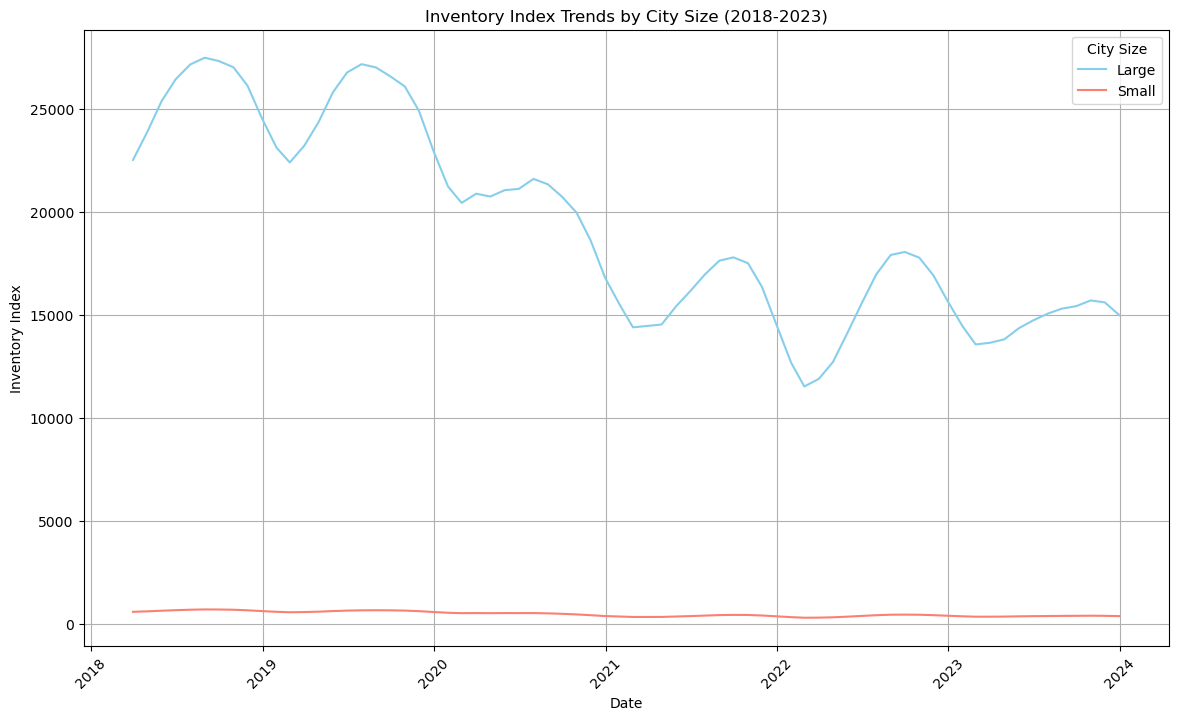

In [529]:

import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame combining both large and small cities data
combined_df = pd.concat([
    large_cities_inventory_trends.assign(CitySize='Large'),
    small_cities_inventory_trends.assign(CitySize='Small')
])

# Plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=combined_df, x=combined_df.index, y='Inventory Index', hue='CitySize', palette={'Large': 'skyblue', 'Small': 'salmon'})

# Adding titles and labels
plt.title('Inventory Index Trends by City Size (2018-2023)')
plt.xlabel('Date')
plt.ylabel('Inventory Index')
plt.legend(title='City Size')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add grid for better readability
plt.show()


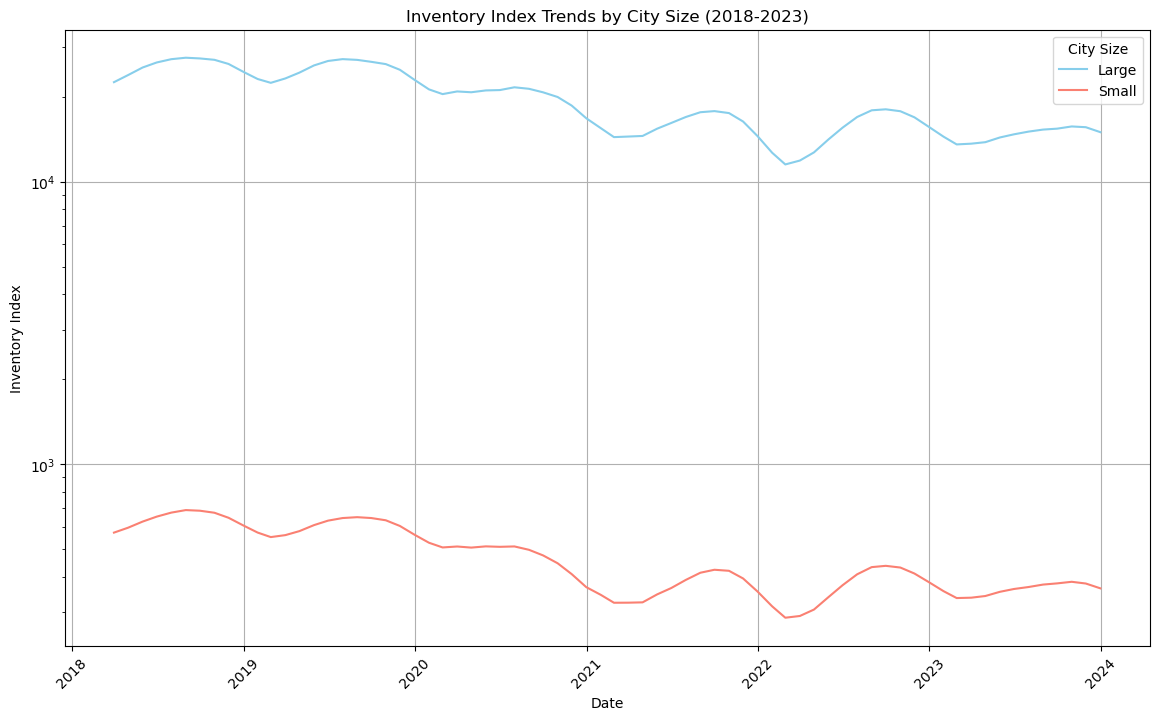

In [533]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame combining both large and small cities data
combined_df = pd.concat([
    large_cities_inventory_trends.assign(CitySize='Large'),
    small_cities_inventory_trends.assign(CitySize='Small')
])

# Plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=combined_df, x=combined_df.index, y='Inventory Index', hue='CitySize', palette={'Large': 'skyblue', 'Small': 'salmon'})

# Adding titles and labels
plt.title('Inventory Index Trends by City Size (2018-2023)')
plt.xlabel('Date')
plt.ylabel('Inventory Index')
plt.legend(title='City Size')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add grid for better readability
plt.yscale('log')  # Apply a logarithmic scale for better comparison
plt.show()
